In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Special function to read special files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

Class = horse
(32, 32, 3)


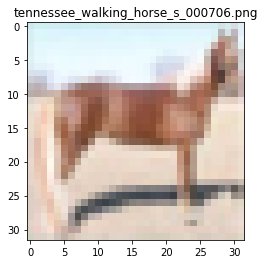

In [2]:
## Visualize the images in CIFAR-10 Dataset
## Here get_data unpickles the CIFAR Dataset and stores the data as 10000*3072 dimension in array X 
## and labels as 10000*1 dimension in array Y. 
## Visualize function shows the image corresponding to id number.

def get_data(file):
    dict = unpickle(file)
    X = np.asarray(dict['data']).astype("uint8")
    Y = np.asarray(dict['labels'])
    names = np.asarray(dict['filenames'])
    list_class=(unpickle("cifar-10/batches.meta")['label_names'])
    return X,Y,names,list_class
                     

def visualize_image(X, Y, names, image_id):
    rgb = X[image_id,:]
    img = rgb.reshape(3, 32, 32).transpose([1, 2, 0])
    print(img.shape)
    plt.imshow(img)
    plt.title(names[image_id])
    plt.show()

# Read image
X, Y, names, classes = get_data("cifar-10/data_batch_3")
# Visualize the 10th image
pick = 10
print("Class =",classes[Y[pick]])
visualize_image(X, Y, names, pick)

In [3]:
## Linear classifier code -
# code to estimate optimal linear boundary,
# classify train data by estimating the optimal linear boundary,
# predict labels based on linear boundary,
# and compute the accuracy of the classification

# code to estimate optimal linear boundary (can ignore for now),
def perceptron_sgd(X, Y):
    w = np.zeros(len(X[0]))
    eta = 0.01 # learning rate
    epochs = 100
    for t in range(epochs):
        if (t+1) % 50 == 0:
            print("Running Epoch #", t+1)
            # print("acc:", compute_accuracy(predict(X[:, :-1], w), Y))
        for i, x in enumerate(X):
            if (np.dot(X[i], w) * Y[i]) <= 0:
                w = w + eta * X[i] * Y[i]
        eta *= 0.75
    return w

# classify train data by estimating the optimal linear boundary,
def classify(train_feat, train_labels):
    ## mapping first label to -1 and second to +1
    labels = np.sort(np.unique(train_labels))
    lmap = {labels[0] : -1, labels[1] : 1}
    l = [lmap[i] for i in train_labels]     
    ## appending 1 to train features
    add_one2train = np.ones((len(train_feat), 1))
    append_train_features = np.hstack((np.asarray(train_feat), add_one2train))
    w = perceptron_sgd(append_train_features, l)
    return w

# predict labels based on linear boundary,
def predict(features, w):
    ##appending 1 to test features
    add_one = np.ones((len(features),1))
    append_features = np.hstack((np.asarray(features), add_one))
    pred = np.dot(append_features, w)
    return pred

# compute the accuracy of the classification
def compute_accuracy(pred, test_labels):
    # To make it general, let us find the unique set of labels in test_labels
    # (could be "apples" and "oranges", or "1" and "2"),
    labels = np.sort(np.unique(test_labels))
    # and then assign -1 and 1 to these unique labels
    lmap = {labels[0] : -1, labels[1] : 1}
    # Let's now convert the labels to -1 and 1
    l = [lmap[i] for i in test_labels]
    # Let us find the accuracy
    p = []
    for i in range(len(pred)):
        p.append(1 if pred[i] >= 0 else -1)
    acc = np.mean(np.asarray(p) == np.asarray(l))
    return acc

In [4]:
# Function for binary classification
def one_vs_one_classifier_ours(train_features, train_labels):
    w = classify(train_features, train_labels)
    return w

def calc_accuracy(X_test, Y_test, w):
    pred = predict(X_test, w)
    accuracy = compute_accuracy(pred, Y_test)
    print("accuracy =", accuracy)

In [5]:
## Unpickling the data and labels from CIFAR-10 Dataset,
## and Preparing the raw features for training and test data.

X_train = []
Y_train = []
# Read all training features and labels
for j in "12345": 
    batch_file = 'cifar-10/data_batch_'+ j
    x_train, y_train, names_train, classes_train = get_data(batch_file)
    X_train.extend(x_train)
    Y_train.extend(y_train)

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

# Read all test features and labels
X_test, Y_test, names_test, classes_test = get_data("cifar-10/test_batch")

In [6]:
def extract_2classes(class0, class1, X, Y):
    # Select class #0
    X_0 = X[Y == class0]
    Y_0 = Y[Y == class0]
    # Select class #1
    X_1 = X[Y == class1]
    Y_1 = Y[Y == class1]
    # Join the two classes to make the set
    X_2classes = np.vstack((X_0, X_1))
    Y_2classes = np.append(Y_0, Y_1)
    return X_2classes, Y_2classes

In [7]:
# Select classes #5 and #7
X_train_2classes, Y_train_2classes = extract_2classes(5, 7, X_train, Y_train)
X_test_2classes, Y_test_2classes = extract_2classes(5, 7, X_test, Y_test)

In [8]:
# Binary classification for classes 1 and 2 using hand features
w = one_vs_one_classifier_ours(X_train_2classes, Y_train_2classes)

# Find accuracy
calc_accuracy(X_test_2classes, Y_test_2classes, w)

Running Epoch # 50
Running Epoch # 100
accuracy = 0.644


In [9]:
## Hand crafted features. For this we extracted 9 dimension feature for each image.
## Feature consist of min, max and mean intensity values for RGB channel.

# Extract min, max and mean of R, G, and B in each image
# in train
def extract_RGB_min_max_mean(X):
    R, G, B = 1024, 2048, 3072
    R_min = np.reshape(np.min(X[:, :R], axis=1), (len(X), 1))
    R_max = np.reshape(np.max(X[:, :R], axis=1), (len(X), 1))
    R_mean = np.reshape(np.mean(X[:, :R], axis=1), (len(X), 1))
    G_min = np.reshape(np.min(X[:, R:G], axis=1), (len(X), 1))
    G_max = np.reshape(np.max(X[:, R:G], axis=1), (len(X), 1))
    G_mean = np.reshape(np.mean(X[:, R:G], axis=1), (len(X), 1))
    B_min = np.reshape(np.min(X[:, G:B], axis=1), (len(X), 1))
    B_max = np.reshape(np.max(X[:, G:B], axis=1), (len(X), 1))
    B_mean = np.reshape(np.mean(X[:, G:B], axis=1), (len(X), 1))
    return np.hstack((R_min, R_max, R_mean, G_min, G_max, G_mean, B_min, B_max, B_mean))

head_features_train = extract_RGB_min_max_mean(X_train_2classes)
head_features_test = extract_RGB_min_max_mean(X_test_2classes)

In [10]:
head_features_train.shape

(10000, 9)

In [11]:
# Binary classification for classes 1 and 2 using hand features
w = one_vs_one_classifier_ours(head_features_train, Y_train_2classes)

# Find accuracy
calc_accuracy(head_features_test, Y_test_2classes, w)

Running Epoch # 50
Running Epoch # 100
accuracy = 0.5085


In [12]:
## apply pca
from sklearn.decomposition import PCA

def extract_eigenvectors(k, X_train):
    pca = PCA(n_components=k)
    pca.fit(X_train)
    eigen_vectors = pca.components_
    return eigen_vectors, pca

def make_pca_features(eigen_vectors, X):
    return np.transpose(np.dot(eigen_vectors, np.transpose(X)))

In [13]:
# Make pca features
k = 200
eigen_vectors, pca_object = extract_eigenvectors(k, X_train_2classes)
pca_features_train_2classes = make_pca_features(eigen_vectors, X_train_2classes)
pca_features_test_2classes = make_pca_features(eigen_vectors, X_test_2classes)

In [14]:
# Binary classification for classes 1 and 2 using hand features
w = one_vs_one_classifier_ours(pca_features_train_2classes, Y_train_2classes)

# Find accuracy
calc_accuracy(pca_features_test_2classes, Y_test_2classes, w)

Running Epoch # 50
Running Epoch # 100
accuracy = 0.6385


In [15]:
## Try different k values
for k in [800, 1000, 1200, 1400]:
    print("Training with k =", k)
    # Make pca features
    eigen_vectors, pca_object = extract_eigenvectors(k, X_train_2classes)
    pca_features_train = make_pca_features(eigen_vectors, X_train_2classes)
    pca_features_test = make_pca_features(eigen_vectors, X_test_2classes)
    # Binary classification for classes 1 and 2 using hand features
    w = one_vs_one_classifier_ours(pca_features_train, Y_train_2classes)
    # Find accuracy
    calc_accuracy(pca_features_test, Y_test_2classes, w)

Training with k = 800
Running Epoch # 50
Running Epoch # 100
accuracy = 0.6495
Training with k = 1000
Running Epoch # 50
Running Epoch # 100
accuracy = 0.6455
Training with k = 1200
Running Epoch # 50
Running Epoch # 100
accuracy = 0.6405
Training with k = 1400
Running Epoch # 50
Running Epoch # 100
accuracy = 0.6445


In [16]:
# Load the deep features of images
import scipy.io as sio
import numpy as np
features = sio.loadmat('cifar-10/cifar10features.mat')

In [17]:
# Extracting the deep features into training and testing
deep_features_train = features['x_train']
deep_labels_train = np.squeeze(np.transpose(features['y_train']))
deep_features_test = features['x_test']
deep_labels_test = np.squeeze(np.transpose(features['y_test']))
print(deep_features_train.shape, deep_labels_train.shape, deep_features_test.shape, deep_labels_test.shape)

(50000, 512) (50000,) (10000, 512) (10000,)


In [18]:
# Extract features of class0 and class1
deep_features_train_2classes, deep_labels_train_2classes = extract_2classes(5, 7, deep_features_train, np.squeeze(deep_labels_train))
deep_features_test_2classes, deep_labels_test_2classes = extract_2classes(5, 7, deep_features_test, np.squeeze(deep_labels_test))

In [19]:
# Binary classification for classes 1 and 2 using hand features
w = one_vs_one_classifier_ours(deep_features_train_2classes, deep_labels_train_2classes)

# Find accuracy
calc_accuracy(deep_features_test_2classes, deep_labels_test_2classes, w)

Running Epoch # 50
Running Epoch # 100
accuracy = 0.9795


In [20]:
# Raw features
print(X_train.shape, X_test.shape)

(50000, 3072) (10000, 3072)


In [21]:
# Extract hand features for full training and test sets
head_features_train = extract_RGB_min_max_mean(X_train)
head_features_test = extract_RGB_min_max_mean(X_test)

In [22]:
print(head_features_train.shape, head_features_test.shape)

(50000, 9) (10000, 9)


In [23]:
# Extract pca features for full training and test sets
# Make pca features, with k=200
k = 200
eigen_vectors, pca_object = extract_eigenvectors(k, X_train)
pca_features_train = make_pca_features(eigen_vectors, X_train)
pca_features_test = make_pca_features(eigen_vectors, X_test)

In [24]:
print(pca_features_train.shape, pca_features_test.shape)

(50000, 200) (10000, 200)


In [25]:
# Deep features
print(deep_features_train.shape, deep_features_test.shape)

(50000, 512) (10000, 512)


In [26]:
import itertools
import operator
import random
import collections
from scipy import stats
from sklearn.metrics import accuracy_score

def extract_two_classes(data, x,y):
    xtrain = []
    ytrain = []
    merged = []
    merged.extend(data[x])
    merged.extend(data[y])
    random.shuffle(merged)
    xtrain = list(zip(*merged))[0]
    ytrain = list(zip(*merged))[1]
    return xtrain, ytrain

def oneVsone(data, num_classes, test_sample):
    weight = []
    prediction = []
    for i, j in list(itertools.combinations(range(num_classes), 2)):
        print("Training for classes", i, j)
        xtrain, ytrain = extract_two_classes(data, i,j)
        w = classify(xtrain, ytrain)
        weight.append((w,(i,j)))
        pred = []
        preds = predict(test_sample, w)
        for p in predict(test_sample, w):
            if p > 0:
                pred.append(j)
            else:
                pred.append(i)
        prediction.append(pred)
        res = stats.mode(np.asarray(prediction))[0]
    return np.squeeze(res)


def multiclass_classification(X_train, Y_train, X_test, Y_test):

    ## Train features and labels you want to use
    xtrain = X_train
    ytrain = Y_train
    ## Test features and labels you want to check on
    xtest = X_test
    ytest = Y_test

    l = zip(xtrain,  ytrain)
    #L.sort(key=lambda x: x[1])
    L = sorted(l, key=lambda x: x[1])

    it = itertools.groupby(L, operator.itemgetter(1))
    All_classes = []

    for key, subiter in it:
#         print ('Class:', key)
        data = []
        for item in subiter:
            data.append(item)
        All_classes.append(data)

    pred = oneVsone(All_classes, len(np.unique(Y_train)), xtest)
    print(accuracy_score(ytest, pred))

In [27]:
# FEATURES & LABELS
#HOMEWORK
train_features = deep_features_train
train_labels = Y_train
test_features = deep_features_test
test_labels = Y_test

In [28]:
multiclass_classification(train_features, train_labels, test_features, test_labels)

Training for classes 0 1
Running Epoch # 50
Running Epoch # 100
Training for classes 0 2
Running Epoch # 50
Running Epoch # 100
Training for classes 0 3
Running Epoch # 50
Running Epoch # 100
Training for classes 0 4
Running Epoch # 50
Running Epoch # 100
Training for classes 0 5
Running Epoch # 50
Running Epoch # 100
Training for classes 0 6
Running Epoch # 50
Running Epoch # 100
Training for classes 0 7
Running Epoch # 50
Running Epoch # 100
Training for classes 0 8
Running Epoch # 50
Running Epoch # 100
Training for classes 0 9
Running Epoch # 50
Running Epoch # 100
Training for classes 1 2
Running Epoch # 50
Running Epoch # 100
Training for classes 1 3
Running Epoch # 50
Running Epoch # 100
Training for classes 1 4
Running Epoch # 50
Running Epoch # 100
Training for classes 1 5
Running Epoch # 50
Running Epoch # 100
Training for classes 1 6
Running Epoch # 50
Running Epoch # 100
Training for classes 1 7
Running Epoch # 50
Running Epoch # 100
Training for classes 1 8
Running Epoch #

In [29]:
actual_labels = np.array([(i, j) for i in range(10) for j in range(i+1, 10)]).T

print(actual_labels)

def extract_2classes_with_binary_labels(i, j, X, Y):
    # Select class #0
    X_0 = X[Y == i]
    Y_0 = np.zeros((len(X_0)))
    # Select class #1
    X_1 = X[Y == j]
    Y_1 = np.ones((len(X_1)))
    # Join the two classes to make the set
    X_2classes = np.vstack((X_0, X_1))
    Y_2classes = np.append(Y_0, Y_1)
    return X_2classes, Y_2classes

# one-vs-one classifier
from sklearn import linear_model
def one_vs_one_classifier(train_features, train_labels):
    clf = linear_model.SGDClassifier(random_state=1)
    clf.fit(train_features, train_labels)
    return clf


def multiclass_classify_using_sklearn(X_train, Y_train, X_test, Y_test):
    
    classifiers = []
    
    # For each pair of classes:
    for i in range(0, 9):
        for j in range(i+1, 10):
            print("Training pair of classes:", i, j)
            
            # Extract the train features and labels of the two classes
            train_features, train_labels = extract_2classes_with_binary_labels(i, j, X_train, Y_train)
            
            # Let us make each one-vs-one classifier
            # Train the classifier on these features and labels
            clf = one_vs_one_classifier(train_features, train_labels)
            classifiers.append(clf)
    
    # Find each classifier's prediction
    predicted_classes_from_all_classifiers = np.zeros((len(X_test), len(classifiers)), dtype=int)
    for c, clf in enumerate(classifiers):
        preds = np.asarray(clf.predict(X_test), dtype=int)
        predicted_classes_from_all_classifiers[:, c] = actual_labels[preds, c]

    # Take majority vote for each sample
    predicted_classes = []
    for p in predicted_classes_from_all_classifiers:
        predicted_classes.append(np.argmax(np.bincount(p)))
    
    # Find accuracy
    test_accuracy = np.mean(predicted_classes == Y_test)
    print(test_accuracy)

[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 5
  5 5 5 6 6 6 7 7 8]
 [1 2 3 4 5 6 7 8 9 2 3 4 5 6 7 8 9 3 4 5 6 7 8 9 4 5 6 7 8 9 5 6 7 8 9 6
  7 8 9 7 8 9 8 9 9]]


In [30]:
multiclass_classify_using_sklearn(train_features, train_labels, test_features, test_labels)

Training pair of classes: 0 1
Training pair of classes: 0 2
Training pair of classes: 0 3
Training pair of classes: 0 4
Training pair of classes: 0 5
Training pair of classes: 0 6
Training pair of classes: 0 7
Training pair of classes: 0 8
Training pair of classes: 0 9
Training pair of classes: 1 2
Training pair of classes: 1 3
Training pair of classes: 1 4
Training pair of classes: 1 5
Training pair of classes: 1 6
Training pair of classes: 1 7
Training pair of classes: 1 8
Training pair of classes: 1 9
Training pair of classes: 2 3
Training pair of classes: 2 4
Training pair of classes: 2 5
Training pair of classes: 2 6
Training pair of classes: 2 7
Training pair of classes: 2 8
Training pair of classes: 2 9
Training pair of classes: 3 4
Training pair of classes: 3 5
Training pair of classes: 3 6
Training pair of classes: 3 7
Training pair of classes: 3 8
Training pair of classes: 3 9
Training pair of classes: 4 5
Training pair of classes: 4 6
Training pair of classes: 4 7
Training p